# Описание проекта

Одна из основных задач в этом наборе данных - предсказать на основе заданных характеристик пациента, есть ли у этого конкретного человека заболевание сердца или нет, а другая - экспериментальная задача по диагностике и получению различных сведений из этого набора данных, которые могли бы помочь в большем понимании проблемы.

### Предобработка и исследовательский анализ данных

In [835]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from pandas_profiling import ProfileReport

# пайплайны
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# импорт моделей
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


# импорт утилит
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# импорт метрик
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report,confusion_matrix


In [836]:
data = pd.read_csv('heart_disease_uci.csv')
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Признаки:
* `id` - уникальный индетификатор пациента
* `age` - возраст пациента в годах
* `origin` - место учебы
* `sex` - пол
* `cp` - тип боли в груди (typical angina, atypical angina, non-anginal, asymptomatic)
* `trestbps` -  кровяное давление в состоянии покоя
* `chol` - сывороточный холестерин в мг/дл
* `fbs` - если уровень сахара в крови натощак > 120 мг/дл (True, False)
* `restecg` - результаты электрокардиографии в состоянии покоя (normal, stt abnormality, lv hypertrophy)
* `thalach` -  достигнутая максимальная частота сердечных сокращений
* `exang` - стенокардия, вызванная физической нагрузкой (True/ False)
* `oldpeak` -  Депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом
* `slope` - наклон пикового сегмента ST упражнения
* `ca` - количество крупных сосудов (0-3), окрашенных при рентгеноскопии
* `thal` - (normal, fixed defect, reversible defect)

Целевой признак
* `num` -  категориальная переменная (0, 1, 2, 3 ,4), где значения это риски.

In [837]:
# удалим индетификатор
data = data.drop(['id'], axis=1)

In [838]:
profile = ProfileReport(data, title="Heart Disease UCI")
profile.to_notebook_iframe()

В датасете присутствуют пропуски их 12.7% и отсутствуют дубликаты. Проанализируем признаки, избавимся от аномальных значений (если есть) и заполним пропуски.

#### Числово признак age (Возраст)

* Пропуски отсутствуют, нулевые или аномальные значения так же.
* Q1 ~ Медиана ~ Q3  какого либо существенного перекоса нет, т.к квантели примерно равно удалены  от медианы.
* Минимум в 1.7 раза меньше чем Q1 
* Максимум в 1.3 раза больше чем Q3

В данном признаке есть редкие значения, но выбросами их не считаем. <br>
Распределение смещено влево.

#### Категориальный признак - sex (Пол)

Отсутствуют пустые значения, значительный перекос в сторону мужчин:
* Male - 78.9% или 726 мужчин
* Female - 21.1% или 194 женщины

In [839]:
# проверим значение на правильность ввода
data['sex'].unique()

array(['Male', 'Female'], dtype=object)

#### Категориальный признак - dataset (Где происходил сбор информации)

* Пропуски отсутствуют

In [840]:
# проверим значение на правильность ввода
data['dataset'].unique()

array(['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
      dtype=object)

#### Категориальный признак - cp (Тип боли в груди)

* Пропуски отсутствуют

In [841]:
# проверим значение на правильность ввода
data['cp'].unique()

array(['typical angina', 'asymptomatic', 'non-anginal', 'atypical angina'],
      dtype=object)

#### Числовой признак trestbps (Кровяное давление в состоянии покоя)

* Присутствуют пропуски и нулевые значения
* Q1 ~ Медиана ~ Q3
* Медиана меньше среднего, а значит больше людей обращаются с повышенным давлением 

Для заполнения пропусков сгруппируем данные по возрасту и месту сбора информации.

In [842]:
# Создадим еще один столбец category_age для распределения числового признака по категориям
# Необходимо для группировки и заполнения пустых значений признака trestbps

data['category_age'] = data['age'].apply(lambda x: 'young' if x <= 30 else 'middle' if x <= 50 else 'old')
data.head(3)

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,category_age
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,old
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,old
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,old


In [843]:
# сгруппируем данные по возрасту и месту получения информации
# заполним пропуски исходя из полученного датасета

data_age_dataset = data.groupby(by=['category_age', 'dataset']).agg({'category_age':'count', 'trestbps': 'median'})
data_age_dataset.head(3)

data.loc[data['trestbps'].isna(), 'trestbps'] = data[data['trestbps'].isna()].apply(
    lambda row: data_age_dataset['category_age'][row['category_age']][row['dataset']], 
    axis=1)  

print('Кол-во пустых строк:', data[data['trestbps'].isna()]['trestbps'].count())   


Кол-во пустых строк: 0


#### Числовой признак - chol (сывороточный холестерин в мг/дл)

* Присутствуют пропуски и нулевые значения
* Q1 = Медиана = Q3
* Медиана меньше среднего, больше людей приходят с нормальным или низким уровнем холестерина.

Холестерин зависит от места обследования, выведем гистрограмму.

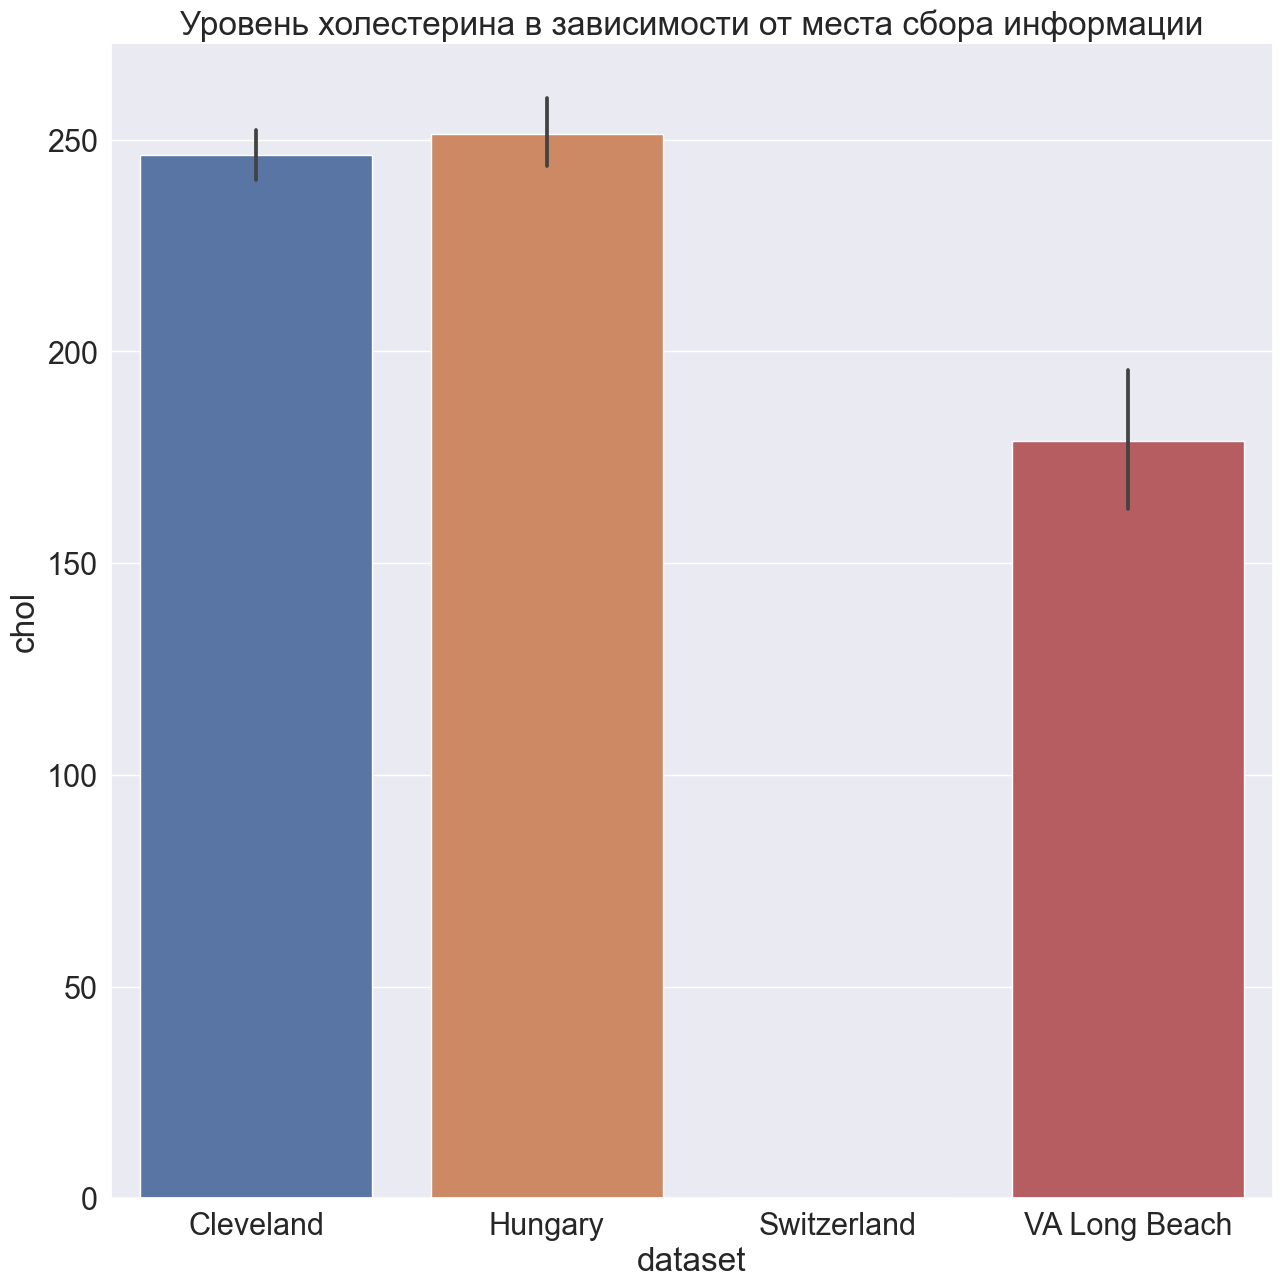

In [844]:
# воспользуемся библиотекой seaborn и matplotlib
# подпишем график

plt.title('Уровень холестерина в зависимости от места сбора информации')   
sns.barplot(x=data['dataset'], y=data['chol']);
plt.show()

В щвейцарии не измеряли уровнь холестерина. Пропусков 3.3%, возможно стоит удалить (?)

Заполним пропуски и посмотрим на нулевые значения.

In [845]:
# выведем кол-во нулевых зна
print('Кол-во нулевых значений:', data[data['chol'] == 0]['chol'].count())

Кол-во нулевых значений: 172


In [846]:
# сгруппируем данные по месту сбора информации
# и возврасту

data_age_dataset = data.groupby(by=['category_age', 'dataset']).agg({'category_age':'count', 'chol': 'median'})
data_age_dataset.head(3)

data.loc[data['chol'] == 0, 'chol'] = data[data['chol'] == 0].apply(
    lambda row: data_age_dataset['category_age'][row['category_age']][row['dataset']], 
    axis=1)
    
print('Кол-во нулевых значений:', data[data['chol'] == 0]['chol'].count())    

Кол-во нулевых значений: 0


In [847]:
# Норма кровяного давления 80 - 130 (найдем среднее т.к тут одно число. 105), 
# повышенное 90 - 140 и выше, (найдем среднее т.к тут одно число. 115)
# сделаем группировку по полу и категории кровяного давления

data['category_trestbps'] = data['trestbps'].apply(lambda x: 'hight' if x > 115 else 'normal' if x > 105 else 'low')

data_sex_cattrestbps = data.groupby(['sex', 'category_trestbps']).agg({'chol': 'mean'})

data.loc[data['chol'].isna(), 'chol'] = data.apply(lambda row: np.floor(data_sex_cattrestbps['chol'][row['sex']][row['category_trestbps']]), axis=1)

##### Категориальный признак - fbs (если уровень сахара в крови натощак > 120 мг/дл)

* Есть пропуски 
* Значения только (True, False)

Заполним пропуски в данном признаке

In [848]:
# создадим доп. столбец, переведем True, False = 1,0
# сгруппируем данные по возрасту и месту сбора инфы
# получим среднее значение
# если среднее больше 0.5, то в пустое поле ставим 1 и наоборот
# таким образом заполним пустые поля 

data['fbs_b_int'] =  data['fbs'].apply(lambda x: 1 if x == True else 0 if x == False else -1);
data_age_dataset = data.groupby(by=['category_age', 'dataset']).agg({'category_age':'count', 'fbs_b_int': 'mean'})
 
data.loc[data['fbs'].isna(), 'fbs_b_int'] = data[data['fbs'].isna()].apply(
    lambda row: 1 if data_age_dataset['fbs_b_int'][row['category_age']][row['dataset']] > 0.5 else 0, 
    axis=1) 

data = data.drop(['fbs'], axis=1)


#### Категориальный признак - restecg (Результаты электрокардиографии в состоянии покоя)

* Есть пропуски

In [849]:
# фиксируем рандомный генератор
# получим уникальные значения
# заполним рандомом 2 значения

random.seed(0)
unique_restecg = data['restecg'].unique()
data.loc[data['restecg'].isna(), 'restecg'] = [unique_restecg[random.randint(0, 2)] for x in range(data[data['restecg'].isna()]['restecg'].shape[0])]

#### Числовой признак - thalch (достигнутая максимальная частота сердечных сокращений)

* Есть пустые значения
* Медиана меньше среднего, а значит у большинства людей макс частота не превышает медианного значения

In [850]:
# заполним рандомом от минимального до максимального значения(?)
print('Минимальное значение:', data['thalch'].min())
print('Максимальное значение:', data['thalch'].max())
print('Кол-во пустых строк до:', data[data['thalch'].isna()].shape[0])

data.loc[data['thalch'].isna(), 'thalch'] = [random.randint(data['thalch'].min(), data['thalch'].max()) 
for x in range(data[data['thalch'].isna()].shape[0])]

print('Кол-во пустых строк после:', data[data['thalch'].isna()].shape[0])

Минимальное значение: 60.0
Максимальное значение: 202.0
Кол-во пустых строк до: 55
Кол-во пустых строк после: 0


#####  Категориальный признак - exang (стенокардия, вызванная физической нагрузкой)

* Есть пропуски
* Значения только (True, False)

Пустые значения могли быть вызваны отсутствием физ. нагрузки. Выведем пустые значения.

In [851]:
# переведем True, False в 1, 0
# заполним рандомными 0 и 1
print('Кол-во пустых строк до:', data[data['exang'].isna()].shape[0])

data.loc[data['exang'].isna(), 'exang'] = [random.randint(0, 1) for x in range(data[data['exang'].isna()].shape[0])]
data['exang'] = data['exang'].apply(lambda x: 1 if x == True else 0)

print('Кол-во пустых строк после:', data[data['exang'].isna()].shape[0])


Кол-во пустых строк до: 55
Кол-во пустых строк после: 0


#### Числовой признак - oldpeak (Депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом)

* Есть пропуски
* Не понятна природа данных, есть ли выбросы и т.д

In [852]:
print('Минимальное значение:', data['oldpeak'].min())
print('Максимальное значение:', data['oldpeak'].max())

print('Кол-во пустых строк до:', data[data['oldpeak'].isna()].shape[0])

data.loc[data['oldpeak'].isna(), 'oldpeak'] = [random.randint(int(data['oldpeak'].min()), int(data['oldpeak'].max())) for x in range(data[data['oldpeak'].isna()].shape[0])]


print('Кол-во пустых строк после:', data[data['oldpeak'].isna()].shape[0])

Минимальное значение: -2.6
Максимальное значение: 6.2
Кол-во пустых строк до: 62
Кол-во пустых строк после: 0


#### Категориальный признак - slope (Наклон пикового сегмента ST упражнения)

* 33.6% пропусков

In [853]:
# рандомим заполнение
data.loc[data['slope'].isna(), 'slope'] = data[data['slope'].isna()]['slope'].apply(lambda x: data['slope'].unique()[random.randint(0, 2)])

#### Категориальный признак - ca (количество крупных сосудов (0-3), окрашенных при рентгеноскопии)

* 66.4% пропусков
* Из-за пропусков тип данных float, а не int

In [854]:
# рандомим заполнение
data.loc[data['ca'].isna(), 'ca'] = data[data['ca'].isna()]['ca'].apply(lambda x: data['ca'].unique()[random.randint(0, 3)])

#### Категориальный признак - thal (Состояние сердца)

* Большое кол-во пропусков 52.8%

In [855]:
# рандомим заполнение
data.loc[data['thal'].isna(), 'thal'] = [data['thal'].unique()[random.randint(0, 2)] 
for x in range(data[data['thal'].isna()].shape[0])]

In [856]:
# итоговый датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                920 non-null    int64  
 1   sex                920 non-null    object 
 2   dataset            920 non-null    object 
 3   cp                 920 non-null    object 
 4   trestbps           920 non-null    float64
 5   chol               920 non-null    float64
 6   restecg            920 non-null    object 
 7   thalch             920 non-null    float64
 8   exang              920 non-null    int64  
 9   oldpeak            920 non-null    float64
 10  slope              920 non-null    object 
 11  ca                 920 non-null    float64
 12  thal               920 non-null    object 
 13  num                920 non-null    int64  
 14  category_age       920 non-null    object 
 15  category_trestbps  920 non-null    object 
 16  fbs_b_int          920 non

#### Приведение данных к нужным типам

In [857]:
# посмотрим на уникальые значения
display(data['trestbps'].unique())
display(data['chol'].unique())
display(data['thalch'].unique())
display(data['oldpeak'].unique())
display(data['ca'].unique())

array([145., 160., 120., 130., 140., 172., 150., 110., 132., 117., 135.,
       112., 105., 124., 125., 142., 128., 170., 155., 104., 180., 138.,
       108., 134., 122., 115., 118., 100., 200.,  94., 165., 102., 152.,
       101., 126., 174., 148., 178., 158., 192., 129., 144., 123., 136.,
       146., 106., 156., 154., 114., 164.,  98., 190., 169., 113.,  92.,
        95.,  29.,  80., 185., 179., 116.,   0.,  21.,  96., 127.])

array([233., 286., 229., 250., 204., 236., 268., 354., 254., 203., 192.,
       294., 256., 263., 199., 168., 239., 275., 266., 211., 283., 284.,
       224., 206., 219., 340., 226., 247., 167., 230., 335., 234., 177.,
       276., 353., 243., 225., 302., 212., 330., 175., 417., 197., 198.,
       290., 253., 172., 273., 213., 305., 216., 304., 188., 282., 185.,
       232., 326., 231., 269., 267., 248., 360., 258., 308., 245., 270.,
       208., 264., 321., 274., 325., 235., 257., 164., 141., 252., 255.,
       201., 222., 260., 182., 303., 265., 309., 307., 249., 186., 341.,
       183., 407., 217., 288., 220., 209., 227., 261., 174., 281., 221.,
       205., 240., 289., 318., 298., 564., 246., 322., 299., 300., 293.,
       277., 214., 207., 223., 160., 394., 184., 315., 409., 244., 195.,
       196., 126., 313., 259., 200., 262., 215., 228., 193., 271., 210.,
       327., 149., 295., 306., 178., 237., 218., 242., 319., 166., 180.,
       311., 278., 342., 169., 187., 157., 176., 24

array([150., 108., 129., 187., 172., 178., 160., 163., 147., 155., 148.,
       153., 142., 173., 162., 174., 168., 139., 171., 144., 132., 158.,
       114., 151., 161., 179., 120., 112., 137., 157., 169., 165., 123.,
       128., 152., 140., 188., 109., 125., 131., 170., 113.,  99., 177.,
       141., 180., 111., 143., 182., 156., 115., 149., 145., 146., 175.,
       186., 185., 159., 130., 190., 136.,  97., 127., 154., 133., 126.,
       202., 103., 166., 164., 184., 124., 122.,  96., 138.,  88., 105.,
       194., 195., 106., 167.,  95., 192., 117., 121., 116.,  71., 118.,
       181., 134.,  90.,  98., 176., 135., 110.,  70., 100.,  87., 102.,
        92.,  91.,  82., 119.,  94., 104.,  60.,  83.,  63.,  77.,  72.,
        78.,  86.,  93.,  67.,  84.,  80., 189., 107., 196.,  69.,  85.,
       201., 193.,  75., 200.,  73.,  76., 199.])

array([ 2.3,  1.5,  2.6,  3.5,  1.4,  0.8,  3.6,  0.6,  3.1,  0.4,  1.3,
        0. ,  0.5,  1.6,  1. ,  1.2,  0.2,  1.8,  3.2,  2.4,  2. ,  2.5,
        2.2,  2.8,  3. ,  3.4,  6.2,  4. ,  5.6,  2.9,  0.1,  2.1,  1.9,
        4.2,  0.9,  1.1,  3.8,  0.7,  0.3,  4.4,  5. , -1. , -1.1, -1.5,
       -0.1, -2.6, -0.7, -2. ,  1.7, -0.8, -0.5, -0.9,  3.7,  6. ])

array([0., 3., 2., 1.])

In [858]:
# выбраные столбцы приведем к целому число
data[['trestbps', 'chol', 'thalch', 'ca']] = data[
     ['trestbps', 'chol', 'thalch', 'ca']
].astype('int')

#### Исследовательский анализ данных

In [859]:
# проверим стольбец trestbps на выбросы
# распределим на категории 

fig = go.Figure()

fig.add_trace(go.Box(y=data['trestbps'].values , name='Давление', marker_color = 'green', boxmean=True))
fig.add_trace(go.Box(y=data[data['sex']=='Male']['trestbps'].values, name ='Мужчины', marker_color = 'blue', boxmean = True))
fig.add_trace(go.Box(y=data[data['sex']=='Female']['trestbps'].values, name ='Женщины', marker_color = 'red', boxmean = True))

fig.update_layout(title = 'КД Распределение', yaxis_title = 'Кровяное давление (mm/Hg)', title_x = 1)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

fig.show()

Не все, что за усами, это выбросы. Равно как не все, что в их пределах, это не выбросы. Диапазон кровянного давления 70 - 150, может быть и выше,  но это признаки заболевания, а вот экстремально низкие можно считать выбросами. Выбросами здесь могут быть точки у нижней границы усов для категории мужчин. 



In [860]:
# удалим значения давления ниже 30
data = data.query('trestbps > 30')

Возможно, кровянное давление зависит от состояния сердца.

In [861]:
fig = go.Figure()
fig.add_trace(go.Violin(y=data['trestbps'].values , name='Все пациенты', marker_color = 'green'))
fig.add_trace(go.Violin(y=data[data['num'] == 0]['trestbps'].values, name ='Отсутствие видимых сердечных заболеваний', marker_color = 'blue'))
fig.add_trace(go.Violin(y=data[data['num'] == 1]['trestbps'].values, name ='Легкая болезнь сердца', marker_color = 'red'))
fig.add_trace(go.Violin(y=data[data['num'] == 2]['trestbps'].values, name ='Умеренная болезнь сердца', marker_color = 'red'))
fig.add_trace(go.Violin(y=data[data['num'] == 3]['trestbps'].values, name ='Тяжелое заболевание сердца', marker_color = 'red'))
fig.add_trace(go.Violin(y=data[data['num'] == 4]['trestbps'].values, name ='Очень тяжелое заболевание сердца', marker_color = 'red'))
fig.update_layout(title = 'Уровень кровянного давления в зависимости от степени болезни сердца', yaxis_title = 'Кровяное давление', title_x = 0.5)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.show() 

При заболевании сердца нижняя планка кровяного давления с 80, поднимается от 90 и выше в зависимости от степени заболевания.

In [862]:
# проверим стольбец chol на выбросы
fig = go.Figure()

fig.add_trace(go.Box(y=data['chol'].values , name='Холестерин', marker_color = 'green', boxmean=True))
fig.add_trace(go.Box(y=data[data['sex']=='Male']['chol'].values, name ='Мужчины', marker_color = 'blue', boxmean = True))
fig.add_trace(go.Box(y=data[data['sex']=='Female']['chol'].values, name ='Женщины', marker_color = 'red', boxmean = True))

fig.update_layout(title = 'УХ Распределение', yaxis_title = 'Уровень холестерина', title_x = 1)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

fig.show()

In [863]:
# удалим значения холестерина ниже 30
data = data.query('chol > 30')

Исследуем уровень холестерина в зависимости от степени болезни сердца.

In [864]:
fig = go.Figure()
fig.add_trace(go.Violin(y=data['chol'].values , name='Все пациенты', marker_color = 'green'))
fig.add_trace(go.Violin(y=data[data['num'] == 0]['chol'].values, name ='Отсутствие видимых сердечных заболеваний', marker_color = 'blue'))
fig.add_trace(go.Violin(y=data[data['num'] == 1]['chol'].values, name ='Легкая болезнь сердца', marker_color = 'red'))
fig.add_trace(go.Violin(y=data[data['num'] == 2]['chol'].values, name ='Умеренная болезнь сердца', marker_color = 'red'))
fig.add_trace(go.Violin(y=data[data['num'] == 3]['chol'].values, name ='Тяжелое заболевание сердца', marker_color = 'red'))
fig.add_trace(go.Violin(y=data[data['num'] == 4]['chol'].values, name ='Очень тяжелое заболевание сердца', marker_color = 'red'))
fig.update_layout(title = 'Уровень холестерина в зависимости от степени болезни сердца', yaxis_title = 'Уровень холестерина', title_x = 0.5)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.show() 

Уровень холестерина меняется в зависимости от болезни сердца, чем диагноз сложнее, тем уровень холестерина выше. Есть так же здоровые люди, но с высоким уровнем холестерина.

In [865]:

fig = go.Figure()
fig.add_trace(go.Violin(y=data[data['exang'] == 0]['thalch'], name ='Стенокардия отсутствует. Макс частота сокращений', marker_color = 'blue'))
fig.add_trace(go.Violin(y=data[data['exang'] == 1]['thalch'], name ='Стенокардия присутствует. Макс частота сокращений', marker_color = 'red'))
fig.update_layout(title = 'Стенокардия и максимальная частота сердечных сокращений (после занятия спортом)', yaxis_title = 'Макс. частота сердечных сокращений', title_x = 0.5)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.show()  

При стенокардии максимальная частота сердечных сокращений ниже, но есть максимальные/минимальные значения сильно выбивающиеся из общей картины.

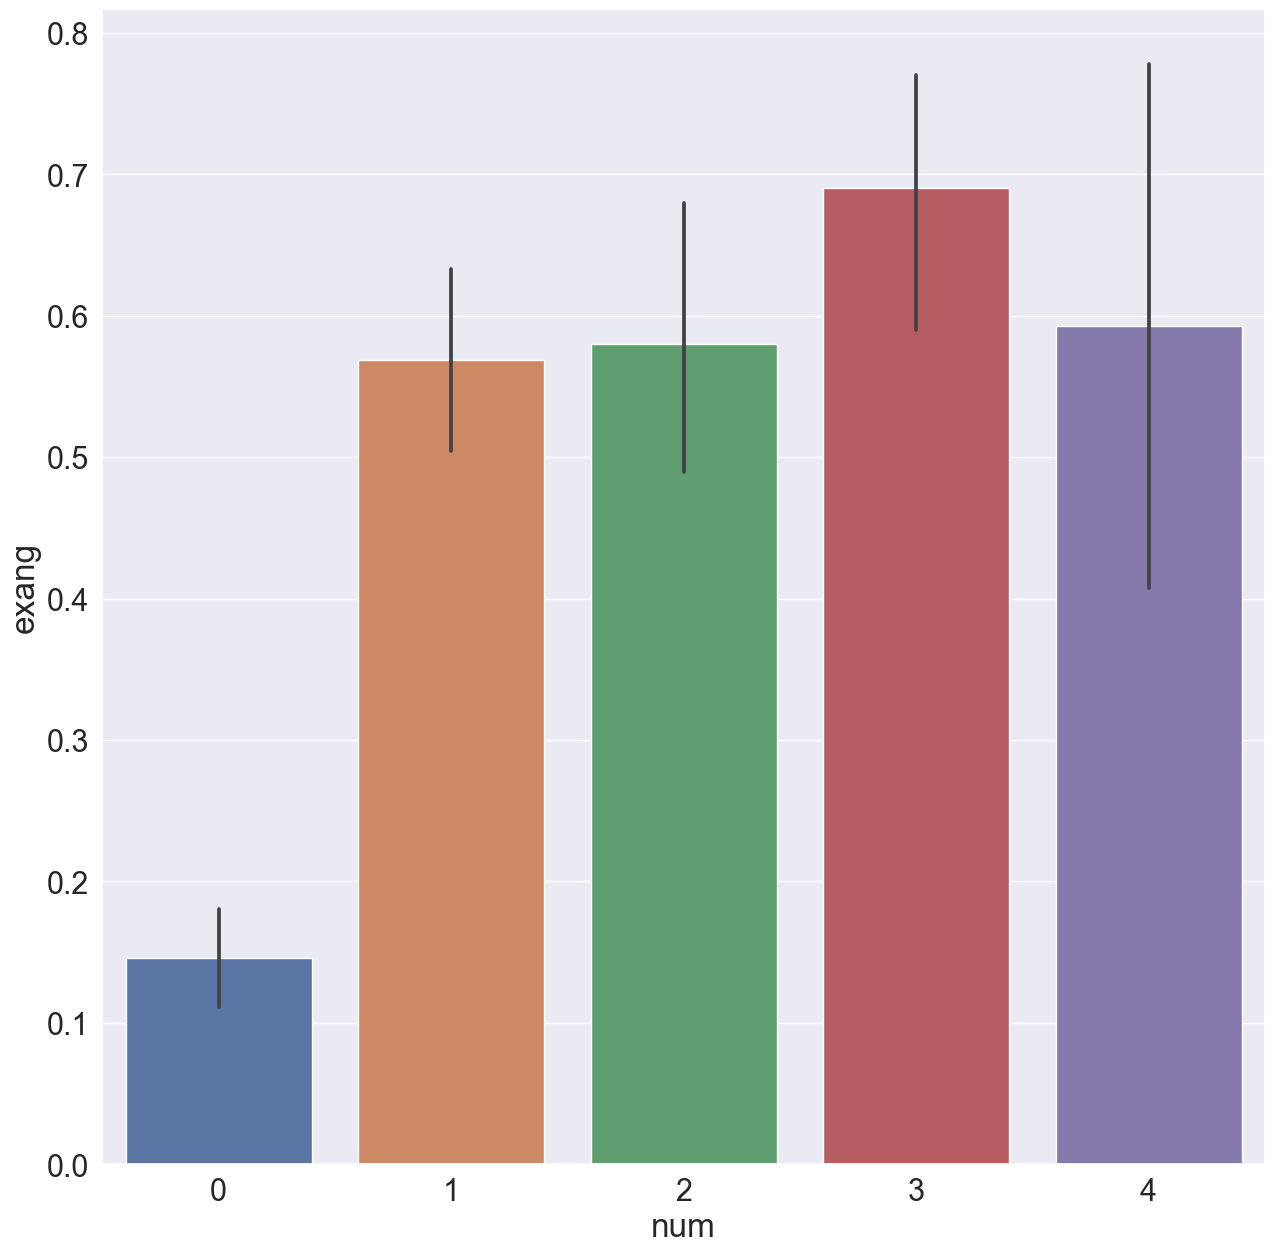

In [866]:
# построим гистограмму

sns.barplot(data=data, y='exang', x='num')
plt.show()

Шанс стенакордии у человека с болещнию сердца более высок. Сравним электрокардиография у больных и не больных пациентов.

In [867]:
fig = go.Figure()
fig.add_trace(go.Violin(y=data[data['restecg'] == 'normal']['num'], name ='Электрокардиография normal', marker_color = 'blue'))
fig.add_trace(go.Violin(y=data[data['restecg'] == 'lv hypertrophy']['num'], name ='Электрокардиография lv hypertrophy', marker_color = 'red'))
fig.add_trace(go.Violin(y=data[data['restecg'] == 'st-t abnormality']['num'], name ='Электрокардиография st-t abnormality', marker_color = 'red'))
fig.update_layout(title = 'Результаты электрокардиографии в состоянии покоя', yaxis_title = 'Макс. частота сердечных сокращений', title_x = 0.5)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.show()  

По результатам электрокардиографи болезнь сердца не определить.

### Baseline модель

Перед тем как стоить модель, определимся с метрикой. Нам важнее найти всех больных, по этому выбираем метрику recall. 

In [868]:
# Удалим вспомогательные столбцы
# Переведем целевой признак в бинарную классификацию
# Т.к  0 - не болен, иначе болен (1, 2, 3)

data = data.drop(['category_age', 'category_trestbps'], axis=1)
data['num'] = data['num'].apply(lambda x: 1 if x > 0 else 0)

In [869]:
# Выведем числовые признаки
numerical_features = data.drop(['num'], axis=1).select_dtypes(include='number').columns.tolist()
print(f'Числовые признаки ({len(numerical_features)}):', '\n')
print(numerical_features)

Числовые признаки (8): 

['age', 'trestbps', 'chol', 'thalch', 'exang', 'oldpeak', 'ca', 'fbs_b_int']


In [870]:
# Выведем категориальные признаки
categorical_features = data.select_dtypes(exclude='number').columns.tolist()
print(f'Категориальные признаки ({len(categorical_features)}):', '\n')
print(categorical_features) 

Категориальные признаки (6): 

['sex', 'dataset', 'cp', 'restecg', 'slope', 'thal']


In [871]:
# Разобьем данные на трейновую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(
    data.drop(['num'], axis=1), data['num'], test_size=0.4, random_state=0)

In [872]:
# используем порядковое кодирования для категориальных переменных
enc = OrdinalEncoder() 
enc.fit(features_train)

features_train[categorical_features] = enc.set_params(encoded_missing_value=-1).fit_transform(features_train[categorical_features]) 
features_valid[categorical_features] = enc.set_params(encoded_missing_value=-1).fit_transform(features_valid[categorical_features])

In [873]:
# приведем числовые признаки к единному формату
scaler = StandardScaler()
scaler.fit(features_train[numerical_features])

features_train[numerical_features] = scaler.transform(features_train[numerical_features])
features_valid[numerical_features] = scaler.transform(features_valid[numerical_features])

In [874]:
# Базовая модель Решающее дерево
model = DecisionTreeClassifier(random_state=0)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

baseline_metrics = pd.DataFrame({
    'Модель': ['Решающее дерево'],
    'Recall': recall_score(target_valid, predicted_valid)
})

print(classification_report(target_valid, predicted_valid))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       162
           1       0.76      0.76      0.76       190

    accuracy                           0.74       352
   macro avg       0.74      0.74      0.74       352
weighted avg       0.74      0.74      0.74       352



In [875]:
# Базовая модель Случайный лес
model = RandomForestClassifier(random_state=0)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

baseline_metrics = pd.concat([baseline_metrics] + [pd.DataFrame({
    'Модель': ['Случайный лес'],
    'Recall': recall_score(target_valid, predicted_valid)
})])

print(classification_report(target_valid, predicted_valid))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       162
           1       0.81      0.87      0.84       190

    accuracy                           0.82       352
   macro avg       0.82      0.81      0.82       352
weighted avg       0.82      0.82      0.82       352



In [876]:
# Базовая модель Лог. регрессия
model = LogisticRegression(random_state=0, solver='liblinear')

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)


baseline_metrics = pd.concat([baseline_metrics] + [pd.DataFrame({
    'Модель': ['Лог. регрессия'],
    'Recall': recall_score(target_valid, predicted_valid)
})])

print(classification_report(target_valid, predicted_valid))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       162
           1       0.80      0.84      0.82       190

    accuracy                           0.80       352
   macro avg       0.80      0.80      0.80       352
weighted avg       0.80      0.80      0.80       352



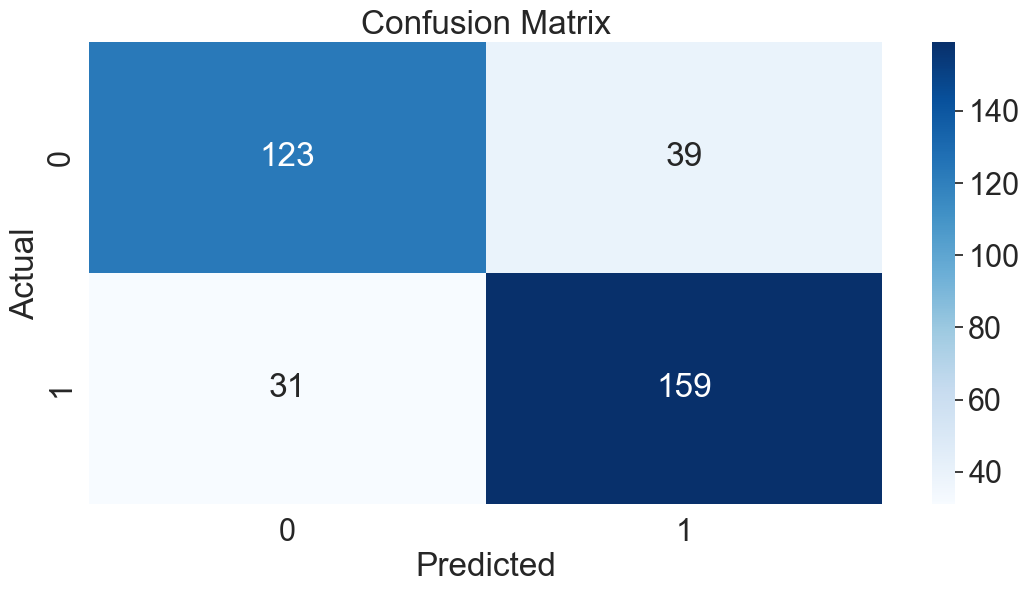

In [877]:
matrix = confusion_matrix(target_valid, predicted_valid)

plt.figure(figsize=(12.8,6))
sns.heatmap(matrix, annot=True, cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

### Разработка модели ML

C:\Temp\ipykernel_4528\1116144079.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



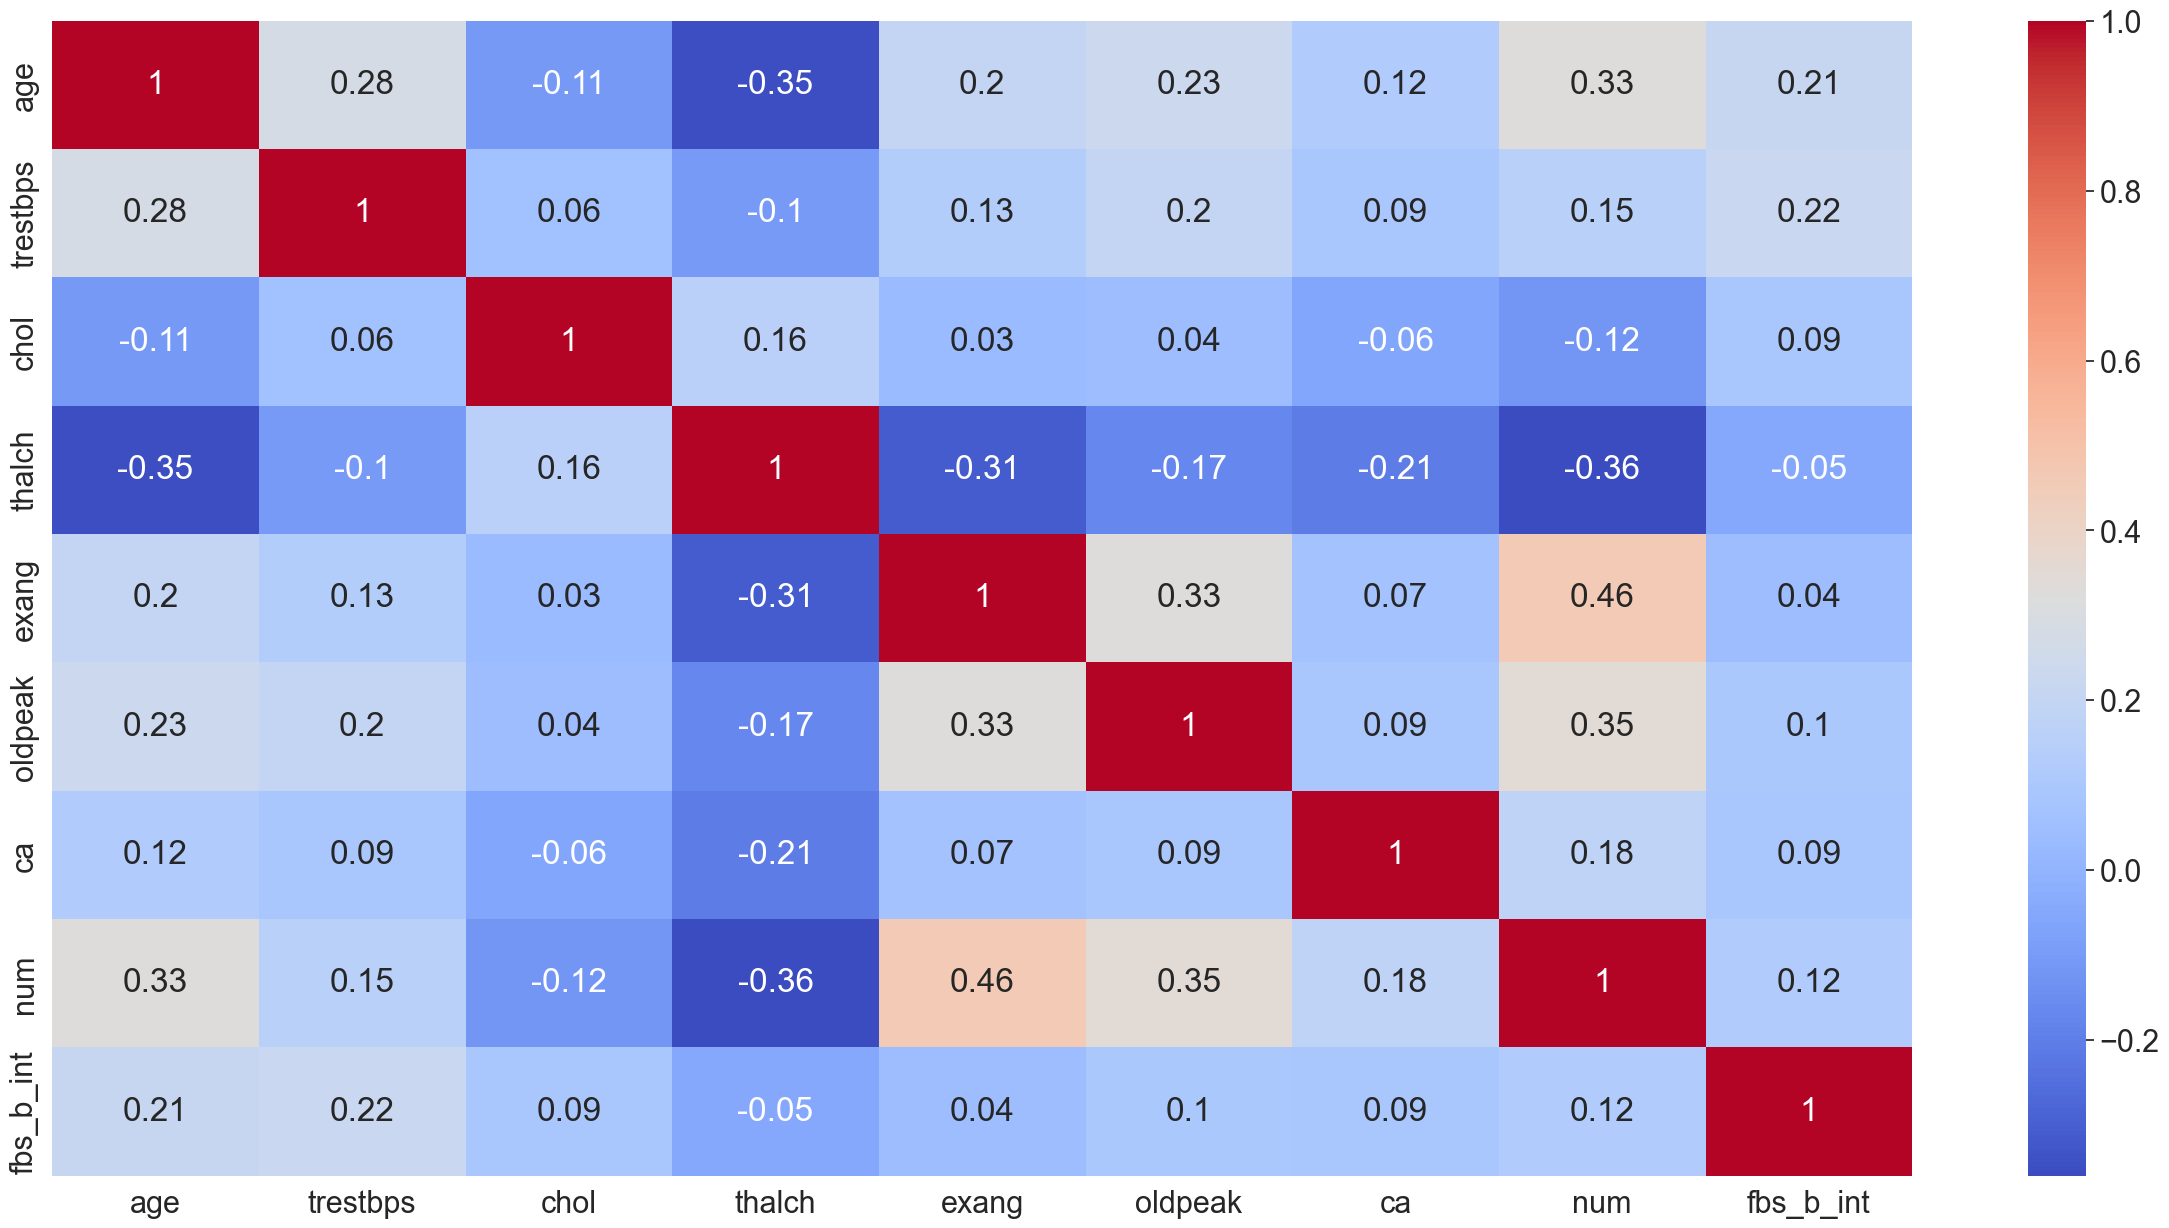

In [878]:
# построим матрицу корреляции
corr_matrix = data.corr().round(2)
sns.set(rc={"figure.figsize":(30, 15)}, font_scale=2)
sns.heatmap(corr_matrix, annot = True, fmt='.2g',cmap= 'coolwarm')
plt.show()


Все признаки являются значимыми для целевого признака. Посмотрим на балансировку классов.

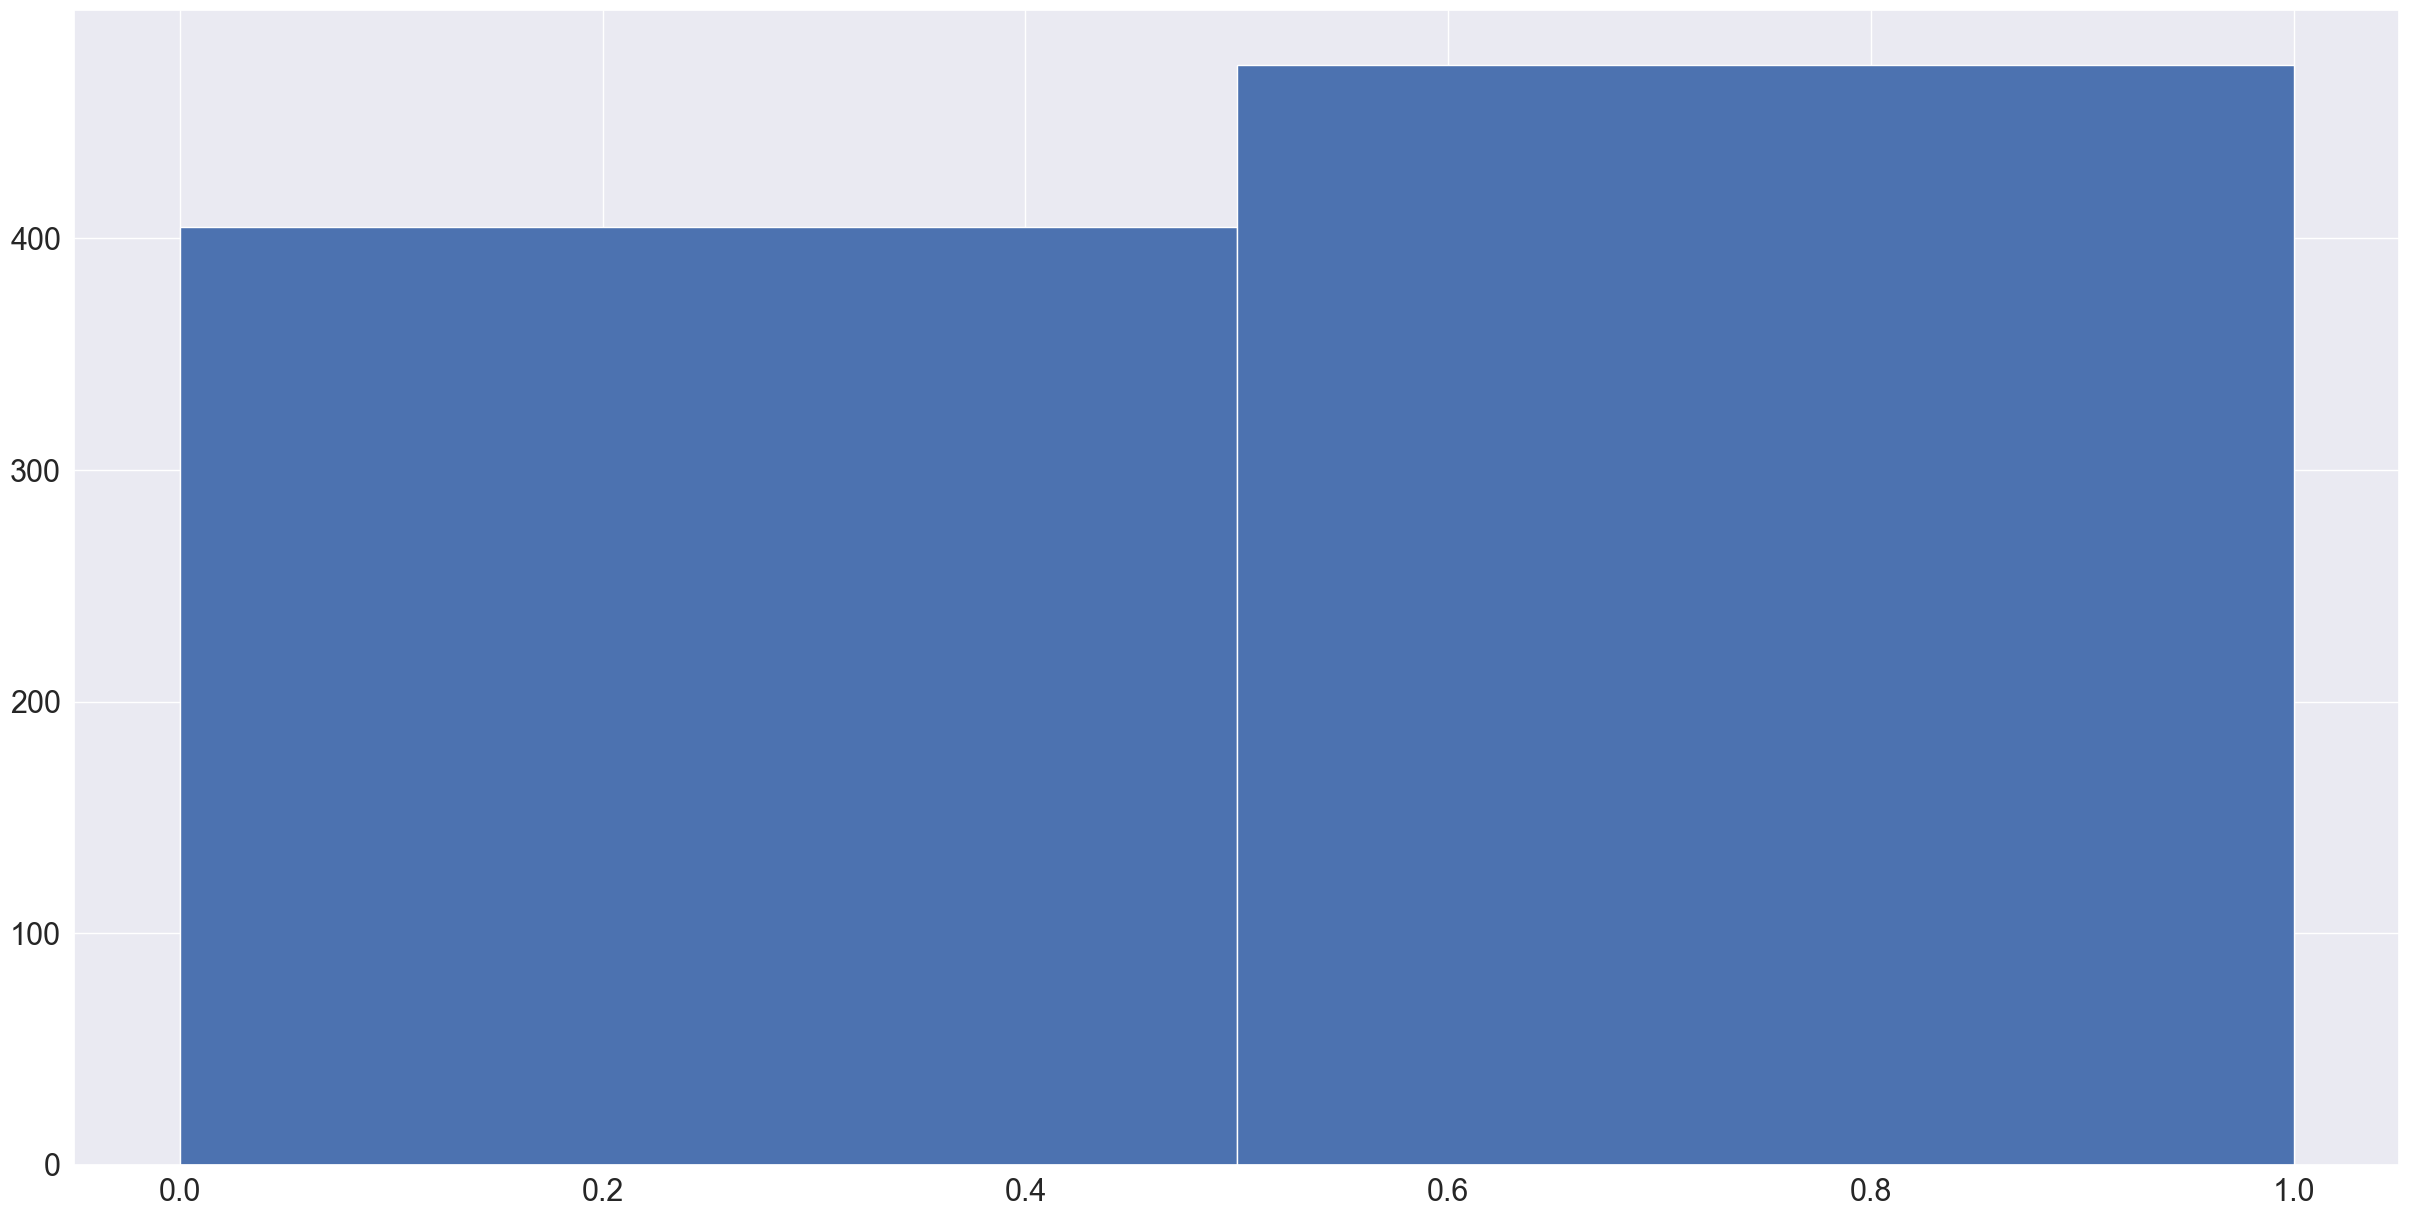

In [879]:
# построим гистограмму на 2а бина
data['num'].hist(bins=2)
sns.set(rc={"figure.figsize":(15, 15)}, font_scale=2)
plt.show()

Присутствует небольшой дисбаланс в сторонку класса "1".

In [880]:
# Построим модель Случайного леса с балансировкой классов
# используем кросс валидацию
model = RandomForestClassifier(class_weight='balanced', random_state=0)

params = {
    'n_estimators': range(50, 175, 25),
    'max_depth': range(8, 12)
} 
 
gs = GridSearchCV(model, params, cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=0), scoring='recall')

gs.fit(features_train, target_train)

predicted_valid = gs.best_estimator_.predict(features_valid)

all_metrics = pd.DataFrame({
    'Модель': ['balanced + cross_val Случайный лес'],
    'Recall': recall_score(target_valid, predicted_valid)
})

print(classification_report(target_valid, predicted_valid))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       162
           1       0.81      0.87      0.84       190

    accuracy                           0.82       352
   macro avg       0.83      0.82      0.82       352
weighted avg       0.82      0.82      0.82       352



<AxesSubplot: >

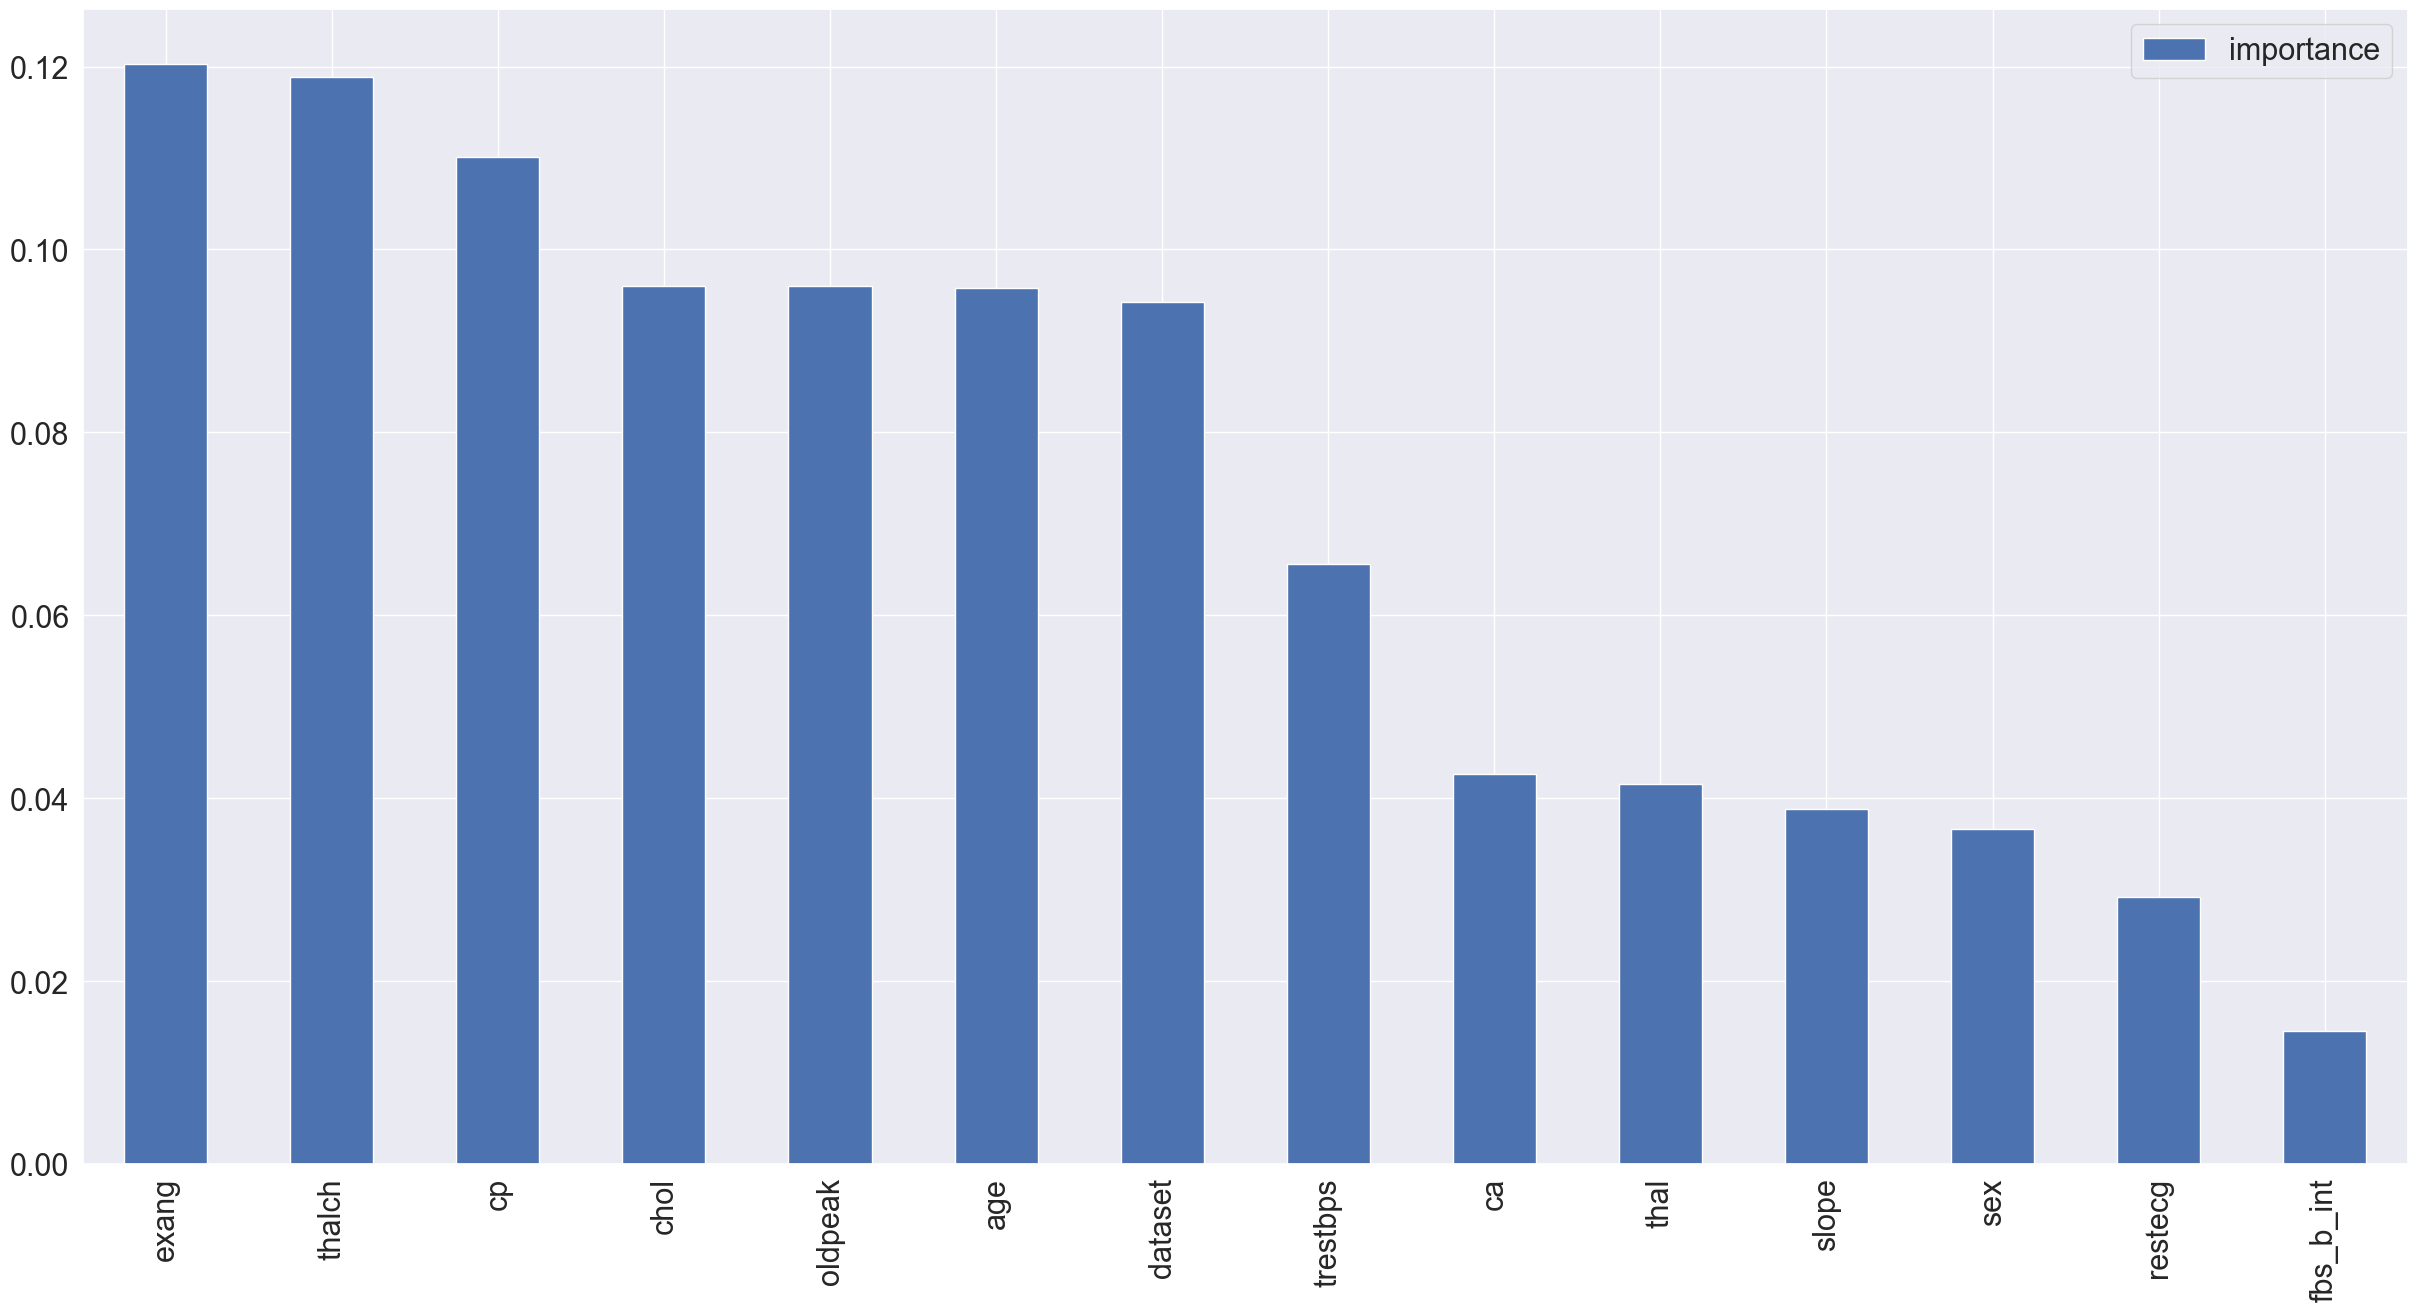

In [881]:
# посмотрим на важность признаков
sns.set(rc={"figure.figsize":(15, 15)}, font_scale=2)

feature_importances = pd.DataFrame(gs.best_estimator_.feature_importances_,
                                       index = features_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)

sns.set(rc={"figure.figsize":(30, 15)}, font_scale=2)
feature_importances.plot(kind='bar')    

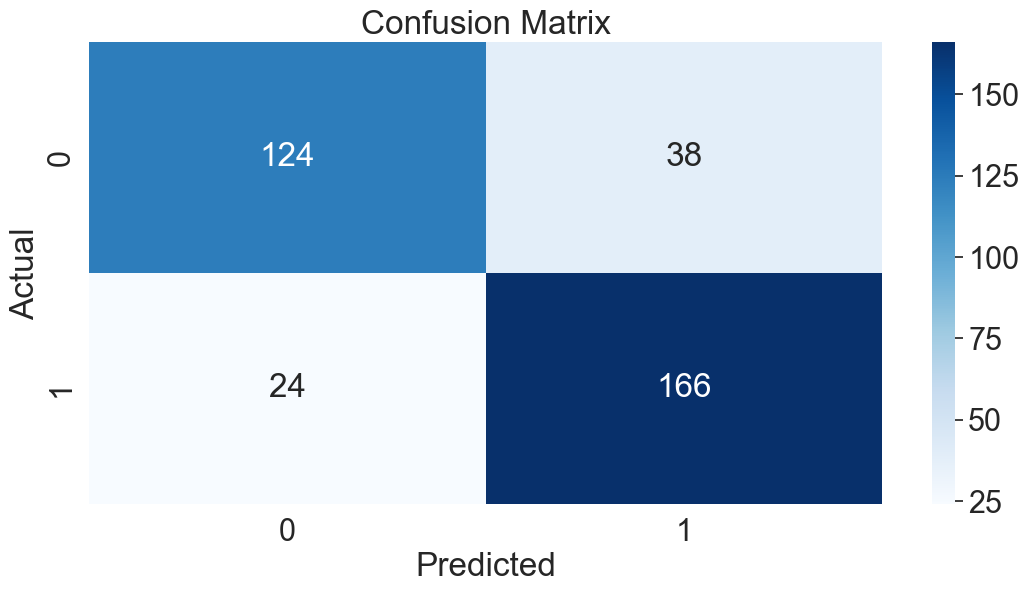

In [882]:
matrix = confusion_matrix(target_valid, predicted_valid)

plt.figure(figsize=(12.8,6))
sns.heatmap(matrix, annot=True, cmap="Blues", fmt="g")
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

Случайный лес с кросс валидацией дал результаты немного лучше (на уровне погрешности), чем базовая модель.

#### Пайплайны

In [883]:
# Используем датасет без предобработки

data_new = pd.read_csv('heart_disease_uci.csv')

data_new['num'] = data_new['num'].apply(lambda x: 1 if x > 0 else 0)

features = data_new.drop(['num', 'id'], axis=1)
target = data_new.num

In [884]:
# Выведем числовые признаки
numerical_features = features.select_dtypes(include='number').columns.tolist()
print(f'Числовые признаки ({len(numerical_features)}):', '\n')
print(numerical_features)

Числовые признаки (6): 

['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']


In [885]:
# Выведем категориальные признаки
categorical_features = features.select_dtypes(exclude='number').columns.tolist()
print(f'Категориальные признаки ({len(categorical_features)}):', '\n')
print(categorical_features) 

Категориальные признаки (8): 

['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [886]:
# предобработка
# для числовых характеристик заполнение средним и стандартизация данных
# для категориальных заполнения по частоте и прямое кодирование
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal-enc', OrdinalEncoder()),
    #('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [887]:
# запускаем в конвеер и преобразуем
# создаем модель Случайного леса с параметрами
# передаем модель в пайплайн 
# в свою очередь пайплайн передаем на кросс валидацию

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

full_processor.fit_transform(features)

model = RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=0)

forest_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', model)
])

gs = GridSearchCV(forest_pipeline, {}, cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=0), scoring='recall')
gs.fit(features, target)

print('recall:', gs.best_score_)


recall: 0.8447712418300654


### Общий вывод

В данном датасете присутствовали выбросы и пустые значения, а в результате анализа был составлен следующий портрет больного: 

* Крайне высокий рист стенокардии, возможно дальнейшее ухудшение работы сердца.
* При стенокардии максимальная частота сердечных сокращений ниже.
* Уровень холестерина меняется в зависимости от болезни сердца, чем диагноз сложнее, тем уровень холестерина выше. Есть так же здоровые люди, но с высоким уровнем холестерина. 
* Кровяное давление выше, чем у людей с отсутствием болезни. 

Перед построением Baseline моделей была выбрана Recall метрика, т.к нам важнее определить как можно больше больных:

In [888]:
# Базовые модели
baseline_metrics

,Модель,Recall
0,Решающее дерево,0.757895
0,Случайный лес,0.868421
0,Лог. регрессия,0.836842


Исходя из значений Recall выбираем лучшую базовую модель и улучшаем ее. В нашем случае Случайный лес показал наилучший результат. Улучшим данное значение кроссвалидацией и балансировкой классов.

In [889]:
all_metrics

,Модель,Recall
0,balanced + cross_val Случайный лес,0.873684


В результате допились почти 1% прироста к Recall метрике.

Так же для решения задачи использовали пайплайны с Случайным лесом и кросс валидацией, результат оказался хуже.

In [890]:
print('Модель Случайного леса (recall):', gs.best_score_)

Модель Случайного леса (recall): 0.8447712418300654
